In [9]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

Read data on Airbnb property listings in Boston (source: https://www.kaggle.com/airbnb/boston)

In [3]:
df = pd.read_csv("listings.csv")
print(df.shape)
df.head() # each row is a unique listing

(3585, 95)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


## What are the key predictors of a property's listing price?

First, we identify both categorical and numerical variables in the raw data that are likely to affect a property's listing price.

In [4]:
df['price'] = df.price.replace('[\$,]', '', regex=True).astype(float)
num_var = ['price','accommodates','bathrooms','bedrooms','beds','minimum_nights','number_of_reviews','review_scores_rating']
cat_var = ['neighbourhood','host_is_superhost','host_identity_verified','property_type','room_type','bed_type','instant_bookable','cancellation_policy']
df = df[num_var + cat_var]

A correlation heatmap gives an initial view of how the quantitative variables are correlated with the response variable - the number of people it can accommodate, number of bedrooms and number of beds have relatively high positive correlation with a property's price on Airbnb.

<AxesSubplot:>

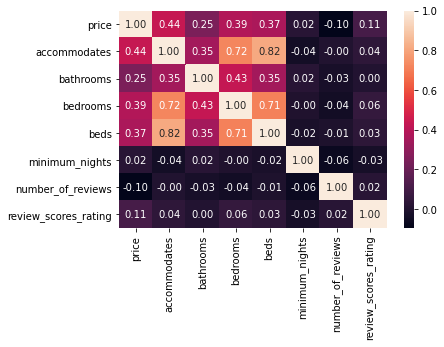

In [5]:
sns.heatmap(df[num_var].corr(), annot=True, fmt=".2f")

We will use the following function to create dummies for categorical variables

In [7]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

Now, we can clean and process the data to obtain a dataframe to which a model can be fitted

In [8]:
# drop rows that have NaN values in the variable that we're interesting in predicting, and columns that contain only NaN values
df2 = df.dropna(subset=['price'])
df2 = df2.dropna(how='all', axis=1)
# impute NaN values in numeric columns with the median of each column
df2 = df2.fillna(df2.median(), axis=0)
# create dummies out of categorical variables
df2 = create_dummy_df(df2, cat_var, dummy_na=True)
df2.head()

,price,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,neighbourhood_Back Bay,neighbourhood_Beacon Hill,...,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,instant_bookable_t,instant_bookable_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_nan
0,250.0,4,1.5,2.0,3.0,2,0,94.0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,65.0,2,1.0,1.0,1.0,2,36,94.0,0,0,...,0,0,1,0,1,0,1,0,0,0
2,65.0,2,1.0,1.0,1.0,3,41,98.0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,75.0,4,1.0,1.0,2.0,1,1,100.0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,79.0,2,1.5,1.0,2.0,2,29,99.0,0,0,...,0,0,1,0,0,0,0,0,0,0


We next fit a linear regression on our data to predict the listing price of a property in Boston on Airbnb.

The results below show that the linear model explains about 40% of the variation in Airbnb listing prices in Boston. We consider variables whose coefficients are significantly different from 0 at 5% significance level to have a non-zero impact on listing price.

To summarise, the following property features tend to result in a higher price:
- being able to accommodate more people
- having more bathrooms, bedrooms or beds
- fewer reviews 
- higher rating from customer reviews
- located in Back Bay, Beacon Hill, Charlestown, Chinatown, Downtown Crossing, Fenway/Kenmore, Financial District, North End, Roxbury, South Boston, South End, Theater District (relative to Allston-Brighton)
- host is a superhost
- host's identity is not verified
- guest will get entire home (relative to private or shared room)
- strict and super strict cancellation policy (relative to flexible policy)

In [10]:
X = df2.drop(columns='price')
y = df2['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train2 = sm.add_constant(X_train) # add constant to training features
# fit linear model
model = sm.OLS(y_train, X_train2)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     32.67
Date:                Fri, 15 Jan 2021   Prob (F-statistic):          1.18e-277
Time:                        23:03:28   Log-Likelihood:                -17412.
No. Observations:                2868   AIC:                         3.495e+04
Df Residuals:                    2806   BIC:                         3.532e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 -40.1851     31.155     -1.290      0.197    -101.274      20.904
accommodates                            8.5896      2.395      3.586      0.000       3.893      13.286
bathrooms                              29.9282      4.733      6.323      0.000      20.648      39.208
bedrooms                               36.4738      4.356      8.374      0.000      27.933      45.015
beds                                    7.6316      3.609      2.115      0.035       0.555      14.708
minimum_nights                         -0.3904      0.223     -1.753      0.080      -0.827       0.046
number_of_reviews                      -0.1896      0.062     -3.034      0.002      -0.312      -0.067
review_scores_rating                    0.7146      0.242      2.958      0.003       0.241       1.188
neighbourhood_Back Bay                 95.7664      9.660      9.914      0.000      76.825     114.708
neighbourhood_Beacon Hill              80.6037     11.276      7.149      0.000      58.494     102.713
neighbourhood_Brookline                21.4196     40.762      0.525      0.599     -58.506     101.345
neighbourhood_Cambridge                56.0473     47.843      1.171      0.242     -37.763     149.858
neighbourhood_Charlestown              51.1173     14.956      3.418      0.001      21.791      80.444
neighbourhood_Chestnut Hill           -27.5081     54.142     -0.508      0.611    -133.669      78.653
neighbourhood_Chinatown                53.0113     15.081      3.515      0.000      23.440      82.583
neighbourhood_Dorchester              -12.6583     10.567     -1.198      0.231     -33.379       8.062
neighbourhood_Downtown                 68.9637     47.988      1.437      0.151     -25.131     163.058
neighbourhood_Downtown Crossing       125.4907     24.423      5.138      0.000      77.602     173.380
neighbourhood_East Boston              -1.7915     12.908     -0.139      0.890     -27.101      23.518
neighbourhood_Fenway/Kenmore           73.2330     10.017      7.311      0.000      53.591      92.875
neighbourhood_Financial District      128.4894     34.824      3.690      0.000      60.206     196.773
neighbourhood_Government Center       -27.6829     75.297     -0.368      0.713    -175.325     119.959
neighbourhood_Harvard Square          -43.7323     76.067     -0.575      0.565    -192.885     105.420
neighbourhood_Hyde Park               -27.3996     23.190     -1.182      0.237     -72.871      18.072
neighbourhood_Jamaica Plain             2.0749      9.450      0.220      0.826     -16.454      20.604
neighbourhood_Leather District         86.5212     44.401      1.949      0.051      -0.540     173.583
neighbourhood_Mattapan                -13.6903     34.493     -0.39

Finally, we want to find out how well the model does on the training and test sets.

We can see that the linear model performs a fair bit worse than in predicting prices for the test set, with a root-mean-squared-error of \\$165 (vs $104 for the training set). The magnitude of the error also looks pretty large compared to an average listing price of \\$175 in the test set. Hence, the linear model is likely to be a blunt tool for predicting Airbnb listing prices in Boston, although it is a slight improvement over predicting price using the simple mean.

In [11]:
y_train_pred = results.predict(X_train2)
y_test_pred = results.predict(sm.add_constant(X_test))
train_rmse = mean_squared_error(y_train, y_train_pred)**0.5
test_rmse = mean_squared_error(y_test, y_test_pred)**0.5
test_rmse_naive = mean_squared_error(y_test, [y_train.mean()]*len(y_test))**0.5
print("Train set RMSE (model) = {} \nTest set RMSE (model) = {}\nTest set RMSE (naive prediction using train set mean) = {}"
      .format(round(train_rmse),
              round(test_rmse),
              round(test_rmse_naive)))

Train set RMSE (model) = 105 
Test set RMSE (model) = 165
Test set RMSE (naive prediction using train set mean) = 187
